# Hespress Sentiment analysis in DARIJA

This notebook is done by:
- Reda El Bettioui
- Abdelilah Adriouich
- Abdellatif Laghjaj

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Importing libraries and packages

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, Bidirectional,
    Layer
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import tokenizer_from_json


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import os
import joblib
import json

## Loading and Cleaning dataset

In [3]:
# Load the dataset
df = pd.read_csv("../Sentiment_Analysis.csv")

# Display the shape of the dataset
print(df.shape)

# Display the first 10 rows
display(df.head(10))

(60467, 3)


,id,comment,sentiment
0,0,what happens,0
1,1,😞😞,-1
2,2,ان شاء الله,0
3,3,بالتوفيق ان شاء الله,1
4,4,الحمدلله على كل حال,1
5,5,الله يستر,0
6,6,امين,0
7,7,شكرا لك,1
8,8,ههههههههه,1
9,9,"هههه ضروري بإذن الله , لفقر را عيب ؤ عار ؤ حشومة",-1


In [4]:
# Drop duplicated rows
df = df.drop_duplicates(subset=['comment'])

# Drop rows with missing values
df = df.dropna(subset=['comment', 'sentiment'])

# Display the number of rows and columns after dropping duplicates and missing values
print(df.shape)

(58406, 3)


C:\Users\abdel\AppData\Local\Temp\ipykernel_7516\3956578104.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df, palette='Set2')  # Use a predefined color palette


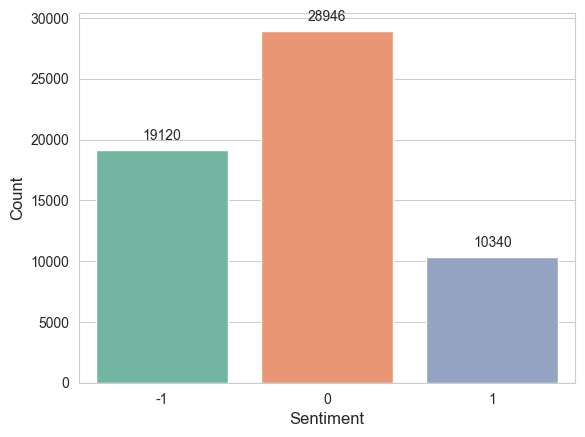

In [5]:
# Set the style for the plot
sns.set_style('whitegrid')

# Create the countplot
ax = sns.countplot(x='sentiment', data=df, palette='Set2')  # Use a predefined color palette

# Annotate each bar with an integer value
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Format as integer
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Set the labels for the axes
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Show the plot
plt.show()

## Building the model

In [6]:
def compute_class_weights(y):
    classes = np.unique(y)
    weights = dict()
    for c in classes:
        weights[c] = len(y) / (len(classes) * np.sum(y == c))
    return weights

In [7]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="normal"
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[1], 1),
            initializer="zeros"
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b), axis=-1)
        at = tf.keras.backend.softmax(et, axis=-1)  # Softmax to get attention weights
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x * at
        return tf.keras.backend.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [8]:
class ArabicSentimentAnalyzer:
    def __init__(self, max_words=100000, max_len=150):
        self.max_words = max_words
        self.max_len = max_len
        self.tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
        self.label_encoder = LabelEncoder()
        self.model = None
        
    def preprocess_text(self, text):
        """Enhanced text preprocessing for Arabic"""
        text = str(text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'[^\u0600-\u06FF\s😀-🙏]', ' ', text)
        
        replacements = {
            'أ': 'ا',
            'إ': 'ا',
            'آ': 'ا',
            'ة': 'ه',
            'ى': 'ي',
            'ئ': 'ي',
        }
        for old, new in replacements.items():
            text = text.replace(old, new)
            
        text = re.sub(r'[\u064B-\u065F\u0670]', '', text)
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        text = re.sub(r'\s+', ' ', text)
        
        return text.strip()
    
    def prepare_data(self, comments, labels, augment=True):
        """Prepare and augment data for training"""
        processed_comments = [self.preprocess_text(comment) for comment in comments]
        
        if augment:
            augmented_comments = []
            augmented_labels = []
            for comment, label in zip(processed_comments, labels):
                augmented_comments.append(comment)
                augmented_labels.append(label)
                if label != 0:
                    words = comment.split()
                    if len(words) > 3:
                        idx = np.random.randint(0, len(words))
                        new_comment = ' '.join(words[:idx] + words[idx+1:])
                        augmented_comments.append(new_comment)
                        augmented_labels.append(label)
        
        final_comments = augmented_comments if augment else processed_comments
        final_labels = augmented_labels if augment else labels
        
        self.tokenizer.fit_on_texts(final_comments)
        sequences = self.tokenizer.texts_to_sequences(final_comments)
        X = pad_sequences(sequences, maxlen=self.max_len, padding='post')
        
        y = self.label_encoder.fit_transform(final_labels)
        
        return X, y
    
    def build_model(self, embedding_dim=300):
        vocab_size = min(len(self.tokenizer.word_index) + 1, self.max_words)
        
        input_layer = Input(shape=(self.max_len,))
        embedding_layer = Embedding(vocab_size, embedding_dim, embeddings_regularizer=tf.keras.regularizers.l2(1e-5))(input_layer)
        
        lstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3))(embedding_layer)
        lstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(lstm_1)

        
        attention_layer = AttentionLayer()(lstm_2)
        
        dense_1 = Dense(256, activation='relu')(attention_layer)
        dropout_1 = Dropout(0.5)(dense_1)
        
        dense_2 = Dense(128, activation='relu')(dropout_1)
        dropout_2 = Dropout(0.5)(dense_2)
        
        output_layer = Dense(3, activation='softmax')(dropout_2)
        
        model = Model(inputs=input_layer, outputs=output_layer)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        self.model = model
        return model
    
    def train(self, X, y, validation_split=0.2, epochs=30, batch_size=32, model_save_path="./sentiment_model.h5", tokenizer_save_path="./tokenizer.json", label_encoder_save_path="./label_encoder.pkl"):
        """Train with improved callbacks and learning rate scheduling"""
        os.makedirs('model_checkpoints', exist_ok=True)
        
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001),
            ModelCheckpoint(filepath='./best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
        ]
        
        class_weights = compute_class_weights(y)
        
        history = self.model.fit(
            X, y,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Save model
        self.model.save(model_save_path)
        print(f"Model saved to {model_save_path}")
        
        # Save tokenizer
        tokenizer_json = self.tokenizer.to_json()
        with open(tokenizer_save_path, 'w') as f:
            json.dump(tokenizer_json, f)
        print(f"Tokenizer saved to {tokenizer_save_path}")
        
        # Save label encoder
        joblib.dump(self.label_encoder, label_encoder_save_path)
        print(f"Label encoder saved to {label_encoder_save_path}")
        
        return history
    
    def predict(self, texts):
        processed_texts = [self.preprocess_text(text) for text in texts]
        sequences = self.tokenizer.texts_to_sequences(processed_texts)
        X = pad_sequences(sequences, maxlen=self.max_len, padding='post')
        
        predictions = self.model.predict(X)
        predicted_labels = np.argmax(predictions, axis=1)
        
        return self.label_encoder.inverse_transform(predicted_labels)

## Train the model

In [ ]:
# Create an instance of the ArabicSentimentAnalyzer class
analyzer = ArabicSentimentAnalyzer()

# Prepare the data
X, y = analyzer.prepare_data(
    comments=df['comment'].values,
    labels=df['sentiment'].values,
    augment=True
    )

Let's visualize data distribution across different sentiments after augmentation:

C:\Users\abdel\AppData\Local\Temp\ipykernel_7516\2579700080.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y, palette='Set2')  # Use a predefined color palette


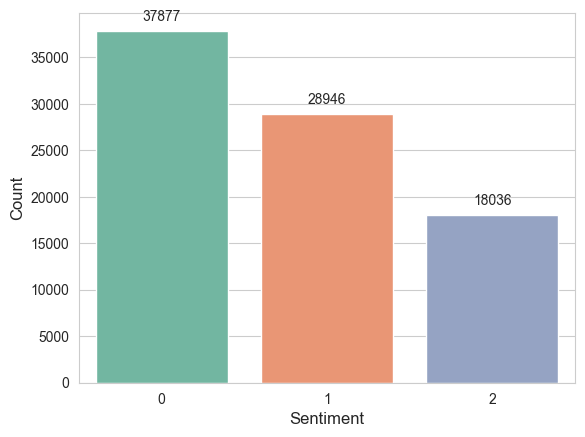

In [10]:
# Set the style for the plot
sns.set_style('whitegrid')

# Create the countplot
ax = sns.countplot(x=y, palette='Set2')  # Use a predefined color palette

# Annotate each bar with an integer value
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Format as integer
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Set the labels for the axes
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Show the plot
plt.show()

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Train the model
model = analyzer.build_model()
history = analyzer.train(X_train, y_train, epochs=30)

Epoch 1/30
1910/1910 [==============================] - 147s 75ms/step - loss: 0.7894 - accuracy: 0.6756 - val_loss: 0.5997 - val_accuracy: 0.7954 - lr: 0.0010
Epoch 2/30
1910/1910 [==============================] - 154s 81ms/step - loss: 0.5093 - accuracy: 0.8555 - val_loss: 0.5563 - val_accuracy: 0.8263 - lr: 0.0010
Epoch 3/30
1910/1910 [==============================] - 143s 75ms/step - loss: 0.3214 - accuracy: 0.9187 - val_loss: 0.5145 - val_accuracy: 0.8518 - lr: 0.0010
Epoch 4/30
1910/1910 [==============================] - 133s 70ms/step - loss: 0.2475 - accuracy: 0.9388 - val_loss: 0.5592 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 5/30
1910/1910 [==============================] - 138s 72ms/step - loss: 0.2347 - accuracy: 0.9416 - val_loss: 0.6039 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 6/30
1910/1910 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9465
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1910/1910 [===============

## Evaluate the model

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

266/266 [==============================] - 7s 26ms/step - loss: 0.5047 - accuracy: 0.8513
Test loss: 0.5047
Test accuracy: 0.8513


266/266 [==============================] - 7s 23ms/step


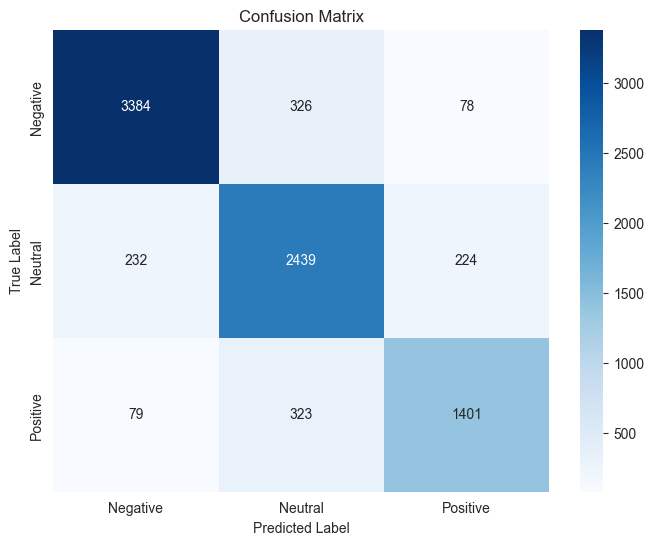

In [20]:
# Get the model's predictions
predictions = model.predict(X_test)

# Convert the predicted labels to the same format as the true labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Saving the model

In [21]:
analyzer.model.save("./")
print("Model saved")

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


Model saved
